Step 1 – Check GPU & install libraries (optional)

In [1]:
import torch
print("Pytorch version:",torch.__version__)
print("CUDA available:",torch.cuda.is_available())
if torch.cuda.is_available():
  print("GPU name:",torch.cuda.get_device_name(0))
else:
  print("Running on CPU (still fine for MINIST")

# if CUDA is True, Colab is using GPU.
# If not, go to Runtime → Change runtime type → Hardware accelerator → GPU.

Pytorch version: 2.9.0+cu126
CUDA available: True
GPU name: Tesla T4


Step 2 – Import required libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt


Step 3 – Set hyperparameters & device

In [3]:
BATCH_SIZE = 64
LR = 1e-3
EPOCHS = 5
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Step 4 – Download MNIST & create DataLoaders

In [4]:
# Transform: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),                      # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # standard MNIST mean & std
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.50MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]

Train samples: 60000
Test samples: 10000


Step 5 – (Optional) Visualize some sample images
###### This is to sanity-check the dataset.


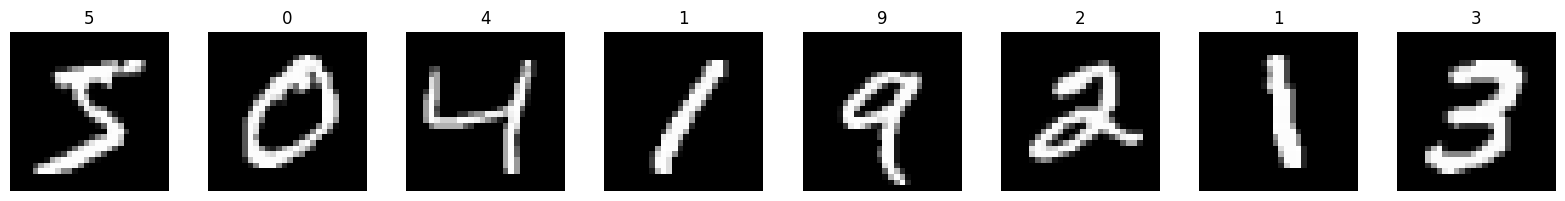

In [6]:
import numpy as np
def show_samples(dataset,num_samples=8):
  fig,axes = plt.subplots(1,num_samples,figsize=(num_samples*2,2))
  for i in range(num_samples):
    img, label = dataset[i]
    img = img.squeeze(0).numpy() #(1,28,28) ->(28,28)
    axes[i].imshow(img,cmap="gray")
    axes[i].set_title(str(label))
    axes[i].axis("off")
  plt.tight_layout()
  plt.show()
show_samples(train_dataset,num_samples=8)

Step 6 – Define the CNN model

In [7]:
class CNNMnist(nn.Module):
    def __init__(self):
        super(CNNMnist, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (1,28,28) -> (32,28,28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                           # (32,28,28) -> (32,14,14)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (32,14,14) -> (64,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                            # (64,14,14) -> (64,7,7)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)  # 10 classes (0–9)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc_layers(x)
        return x  # raw logits


model = CNNMnist().to(device)
print(model)


CNNMnist(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


Step 7 – Set loss function & optimizer

In [8]:
criterion = nn.CrossEntropyLoss()  # multi-class classification
optimizer = optim.Adam(model.parameters(), lr=LR)


Step 8 – Define training & evaluation functions

In [9]:
def train_one_epoch(epoch, model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch}] Batch [{batch_idx+1}/{len(loader)}] "
                  f"Loss: {loss.item():.4f}")

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"==> Epoch [{epoch}] Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device, mode="Test"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"==> {mode} Loss: {epoch_loss:.4f} | {mode} Acc: {epoch_acc:.2f}%")
    return epoch_loss, epoch_acc


Step 9 – Train the model

In [10]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []

best_test_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    print(f"\n==== Epoch {epoch}/{EPOCHS} ====")
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device, mode="Test")

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), "mnist_cnn_best.pth")
        print(f"Saved new best model with test accuracy: {best_test_acc:.2f}%")

print("\nTraining complete.")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")



==== Epoch 1/5 ====
Epoch [1] Batch [100/938] Loss: 0.3914
Epoch [1] Batch [200/938] Loss: 0.2996
Epoch [1] Batch [300/938] Loss: 0.0899
Epoch [1] Batch [400/938] Loss: 0.0866
Epoch [1] Batch [500/938] Loss: 0.0872
Epoch [1] Batch [600/938] Loss: 0.0684
Epoch [1] Batch [700/938] Loss: 0.0471
Epoch [1] Batch [800/938] Loss: 0.1060
Epoch [1] Batch [900/938] Loss: 0.0341
==> Epoch [1] Train Loss: 0.2127 | Train Acc: 93.42%
==> Test Loss: 0.0513 | Test Acc: 98.25%
Saved new best model with test accuracy: 98.25%

==== Epoch 2/5 ====
Epoch [2] Batch [100/938] Loss: 0.0970
Epoch [2] Batch [200/938] Loss: 0.1136
Epoch [2] Batch [300/938] Loss: 0.1174
Epoch [2] Batch [400/938] Loss: 0.0955
Epoch [2] Batch [500/938] Loss: 0.0263
Epoch [2] Batch [600/938] Loss: 0.0143
Epoch [2] Batch [700/938] Loss: 0.0413
Epoch [2] Batch [800/938] Loss: 0.0519
Epoch [2] Batch [900/938] Loss: 0.0133
==> Epoch [2] Train Loss: 0.0803 | Train Acc: 97.67%
==> Test Loss: 0.0340 | Test Acc: 98.83%
Saved new best model

Step 10 – Plot loss & accuracy curves (nice for understanding)

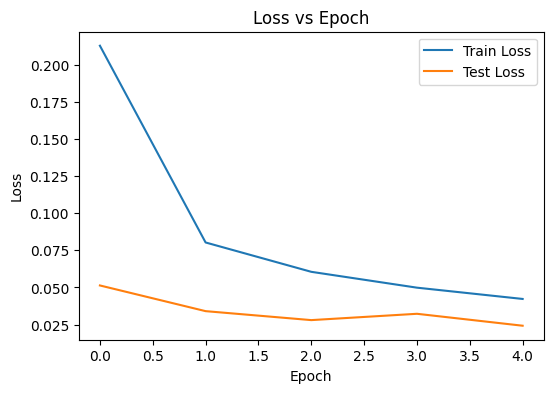

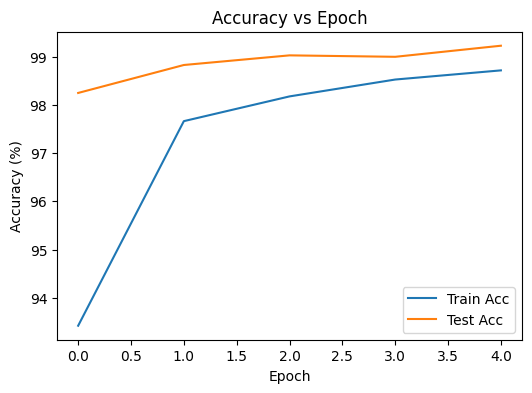

In [11]:
# Loss curves
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.show()

# Accuracy curves
plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.show()


Step 11 – Test on a single image

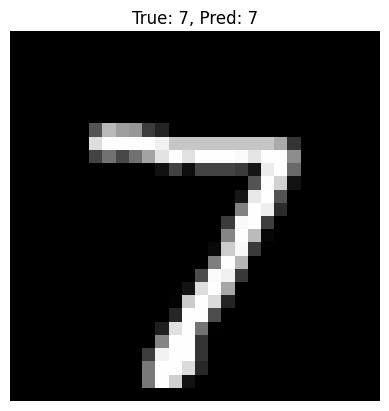

True label: 7, Predicted label: 7


In [14]:
def predict_single_image(model, dataset, index=0):
    model.eval()
    img, label = dataset[index]
    img_vis = img.squeeze(0).numpy()

    with torch.no_grad():
        img_input = img.unsqueeze(0).to(device)  # (1,1,28,28)
        outputs = model(img_input)
        _, predicted = outputs.max(1)
        pred_label = predicted.item()

    plt.imshow(img_vis, cmap="gray")
    plt.title(f"True: {label}, Pred: {pred_label}")
    plt.axis("off")
    plt.show()

    print(f"True label: {label}, Predicted label: {pred_label}")

predict_single_image(model, test_dataset, index=0)
